<a href="https://colab.research.google.com/github/Mudachir/IMAGE-BASED-DETECTION-AND-CLASSIFICATION-OF-PULMONARY-ABNORMALITIES-USING-DEEP-LEARNING-TECHNIQUES/blob/main/CNN_with_vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive  # Importing the correct module to mount Google Drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the paths to the folders
covid_path = '/content/drive/MyDrive/Dataset/COVID'
normal_path = '/content/drive/MyDrive/Dataset/Normal'
lung_opacity_path = '/content/drive/MyDrive/Dataset/Lung_Opacity'
viral_pneumonia_path = '/content/drive/MyDrive/Dataset/Viral Pneumonia'

# Function to get the number of images in each class
def count_images(folder_path):
    return len([file for file in os.listdir(folder_path) if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.jpeg')])

# Count the number of images in each class
covid_count = count_images(covid_path)
normal_count = count_images(normal_path)
lung_opacity_count = count_images(lung_opacity_path)
viral_pneumonia_count = count_images(viral_pneumonia_path)

# Print the results
print(f"Number of images in COVID class: {covid_count}")
print(f"Number of images in Normal class: {normal_count}")
print(f"Number of images in Lung Opacity class: {lung_opacity_count}")
print(f"Number of images in Viral Pneumonia class: {viral_pneumonia_count}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of images in COVID class: 1069
Number of images in Normal class: 975
Number of images in Lung Opacity class: 1150
Number of images in Viral Pneumonia class: 1025


In [ ]:
# Step 2: Set Up Data Generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image parameters
img_height, img_width = 224, 224

# Define ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalization
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.95, 1.05],
    validation_split=0.2
)

# Separate generator for validation (without augmentation)
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training and validation generators
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = valid_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)


Found 3376 images belonging to 4 classes.
Found 843 images belonging to 4 classes.


In [ ]:
# Step 3: Load or Create Model and Prepare for Fine-Tuning
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW, schedules
import os

# Load the saved model if it exists, otherwise create a new model
model_path = '/content/drive/MyDrive/Models/best_model(2).keras'

if os.path.exists(model_path):
    print("Loading the saved model...")
    model = load_model(model_path)
else:
    print("No saved model found. Creating a new model...")
    # Load the VGG19 model with pre-trained weights, excluding the top fully connected layers
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the last 15 layers for fine-tuning
    for layer in base_model.layers[-15:]:
        layer.trainable = True

    # Adding custom layers on top of the base model
    x = base_model.output
    x = Flatten()(x)  # Flatten the output of the base model
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)  # Batch normalization layer
    x = Dropout(0.4)(x)  # dropout rate
    x = Dense(512, activation='relu')(x)  # Additional fully connected layer for more complexity
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(4, activation='softmax')(x)  # Output layer for 4 classes

    model = Model(inputs=base_model.input, outputs=predictions)

# Define learning rate schedule
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)

# Compile the model with a modified optimizer
model.compile(optimizer=AdamW(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Loading the saved model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,005,380 (125.91 MB)

 Trainable params: 22,418,692 (85.52 MB)

 Non-trainable params: 10,586,688 (40.39 MB)

In [ ]:
# Step 4: Define Callbacks and Train the Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights to address class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Class weights to further emphasize minority classes
class_weights[0] *= 1.2  # COVID
class_weights[1] *= 1.1  # Lung Opacity
class_weights[2] *= 1.3  # Normal
class_weights[3] *= 1.4  # Viral Pneumonia

# Define callbacks
checkpoint = ModelCheckpoint(
    model_path,  # Save to Google Drive
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Increased patience for allowing more training flexibility
    restore_best_weights=True,
    verbose=1
)
# Train the model with further fine-tuning
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=70,  # epochs for further training
    callbacks=[checkpoint, early_stopping],
    class_weight=class_weights,  # Added class weights to address imbalance
    verbose=1
)

Epoch 1/70


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9427 - loss: 0.1937
Epoch 1: val_accuracy improved from -inf to 0.90866, saving model to /content/drive/MyDrive/Models/best_model(2).keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 64s 519ms/step - accuracy: 0.9427 - loss: 0.1939 - val_accuracy: 0.9087 - val_loss: 0.3098
Epoch 2/70
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9311 - loss: 0.2150
Epoch 2: val_accuracy did not improve from 0.90866
106/106 ━━━━━━━━━━━━━━━━━━━━ 55s 479ms/step - accuracy: 0.9312 - loss: 0.2148 - val_accuracy: 0.7877 - val_loss: 0.8695
Epoch 3/70
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9401 - loss: 0.1781
Epoch 3: val_accuracy did not improve from 0.90866
106/106 ━━━━━━━━━━━━━━━━━━━━ 54s 473ms/step - accuracy: 0.9401 - loss: 0.1782 - val_accuracy: 0.8399 - val_loss: 0.5684
Epoch 4/70
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9457 - loss: 0.1732
Epoch 4: val_accuracy did not improve from 0.90866
106/106 ━━━━━━━━━━━━━━━━━━━

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9416 - loss: 0.1769
Validation Loss: 0.2002226859331131
Validation Accuracy: 0.9347568154335022


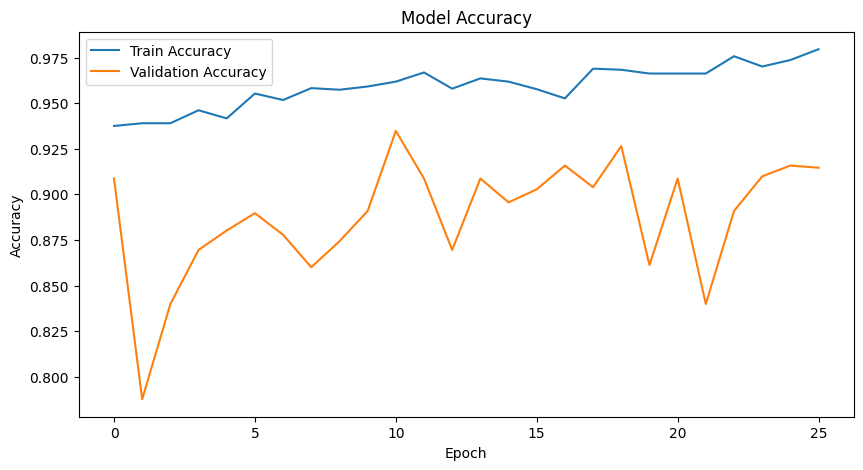

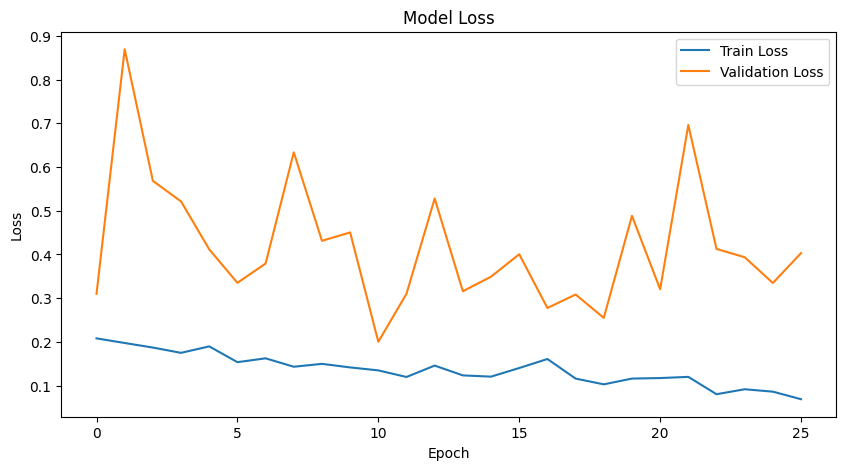

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step


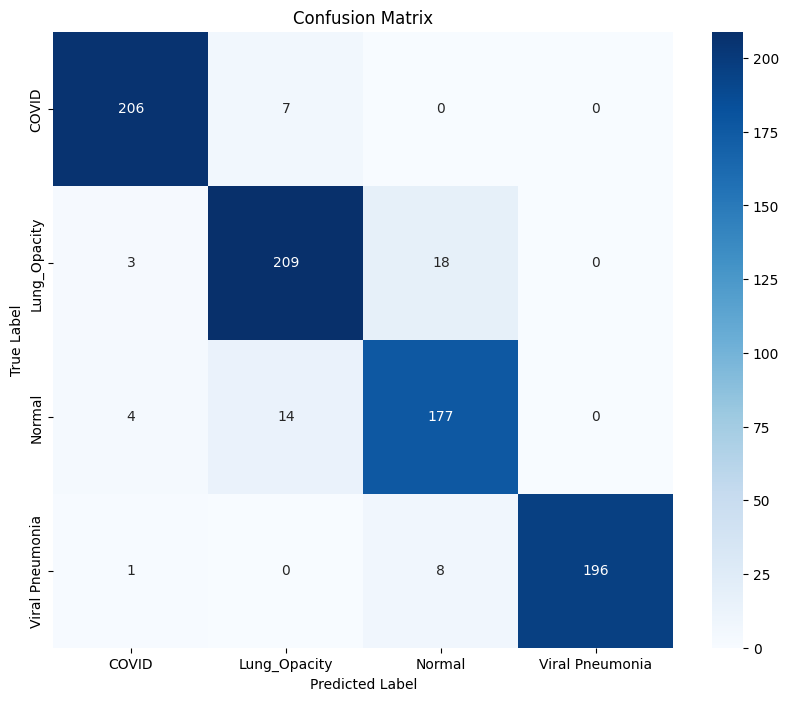

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.96      0.97      0.96       213
   Lung_Opacity       0.91      0.91      0.91       230
         Normal       0.87      0.91      0.89       195
Viral Pneumonia       1.00      0.96      0.98       205

       accuracy                           0.93       843
      macro avg       0.94      0.93      0.94       843
   weighted avg       0.94      0.93      0.94       843

Precision: 0.9360
Recall (Sensitivity): 0.9348
F1 Score: 0.9352
Fine-tuned model saved to /content/drive/MyDrive/Models/best_model(2).keras


In [ ]:
# Step 5: Evaluating the Model Performance
# Evaluate the model on the validation data
evaluation = model.evaluate(validation_generator, verbose=1)
print(f"Validation Loss: {evaluation[0]}")
print(f"Validation Accuracy: {evaluation[1]}")

# Import necessary libraries for plotting
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix
# Get predictions from the model
Y_pred = model.predict(validation_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
true_labels = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
report = classification_report(true_labels, y_pred, target_names=class_labels)
print('Classification Report:')
print(report)

# Precision, Recall, F1-Score, and Sensitivity
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, y_pred, average='weighted')
sensitivity = recall  # In a classification context, recall is often referred to as sensitivity

print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

model.save(model_path)
print(f"Fine-tuned model saved to {model_path}")


In [ ]:
model.save(model_path)
print(f"Fine-tuned model saved to {model_path}")

Fine-tuned model saved to /content/drive/MyDrive/Models/best_model.keras


In [ ]:
# Step 7: Disconnect from Colab GPU to save compute units
from google.colab import runtime
runtime.unassign()
print("Disconnected from GPU to save compute units.")
